# TM470 Project - Automating the Identification of UK Coarse Fish

In [1]:
import tensorflow as tf
import kaggle
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit #scikit-learn.org
from sklearn.model_selection import train_test_split
import pathlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as et # https://docs.python.org/3/library/xml.etree.elementtree.html
from tensorflow.python.client import device_lib #for detection of devices
import glob as glob # Searches for certain files
# for model
from tensorflow.keras import Sequential, optimizers, metrics, layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

## Assign the dataset path

In [2]:
# Dataset address is C:\\Users\\Rob\\Dataset
datasetPath = (r'C:\\Users\\Rob\\Dataset')#(r'C:\\Users\\Rob\\Dataset')

In [3]:
# Assigning dataset path to pathlib
dat_dir = pathlib.Path(datasetPath).with_suffix('')
print(dat_dir)

C:\Users\Rob\Dataset


In [4]:
# Number of images in dataset
image_count = len(list(dat_dir.glob('*/*.jpg'))) # is this how datasetPath should be?
print(image_count)

7482


## Get image dimesions, class names and bound box information from XML files (using xml.etree.elementtree.html)

In [5]:
# Reading the information in the XML files and extracting img dimensions, class names and bound box dimensions
path = (dat_dir)
filelist = []
classNameList = []#list()#[]
boundBoxList = []#list()#[]
imgSizeList = []#list()#[]

for root, dirs, files in os.walk(path):
    for file in files:
        if not file.endswith('.xml'):
            continue
        filelist.append(os.path.join(root, file))
for file in filelist:
    root = et.parse(file).getroot() # get the root of the xml
# Get image dimensions
    for imgSize in root.findall('.//size'):
        #image_size = imgSize.find('size').text
        width = int(imgSize.find('./width').text)
        height = int(imgSize.find('./height').text)
        depth = int(imgSize.find('./depth').text)
        #data2 = [xmin,ymin,xmax,ymax])
    imgSizeList.append([width,height,depth])
# Get class names
    for className in root.findall('.//object'):
        class_name = className.find('name').text
        #data = np.array([class_name])
    classNameList.append(class_name)
# Get bounding box information
    for bndBox in root.findall('.//object'):
        bounding_box = bndBox.find('bndbox').text
        xmin = int(bndBox.find('./bndbox/xmin').text)
        ymin = int(bndBox.find('./bndbox/ymin').text)
        xmax = int(bndBox.find('./bndbox/xmax').text)
        ymax = int(bndBox.find('./bndbox/ymax').text)
        #data2 = [xmin,ymin,xmax,ymax])
    boundBoxList.append([xmin,ymin,xmax,ymax]) 

filepaths = list(dat_dir.glob(r'*/*.jpg'))

In [6]:
# print class names and bounding box info lists (list1 and list2)
#for i in range (5):
print(filepaths[0],classNameList[0],boundBoxList[0],imgSizeList[0])

C:\Users\Rob\Dataset\Abramis brama\00a7b0d4-8136-44f3-9e06-9972c1d42039-520mm.jpg Abramis brama [20, 20, 486, 193] [506, 213, 3]


In [7]:
print(len(filepaths)), print(len(classNameList)), print(len(boundBoxList)), print(len(imgSizeList))

7482
7482
7482
7482


(None, None, None, None)

## Create dataframe using filepaths, class names, bound boxes and images size

In [8]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
classNameList = pd.Series(classNameList, name='ClassName')#.astype(str)
boundBoxList = pd.Series(boundBoxList, name='Boundbox')#.astype('float64')
imgSizeList = pd.Series(imgSizeList, name='Size')

dataframe = pd.concat([filepaths,classNameList,boundBoxList, imgSizeList], axis=1)#, boundBoxList,imgSizeList

dataframe.shape


(7482, 4)

In [10]:
dataframe.dtypes

Filepath     object
ClassName    object
Boundbox     object
Size         object
dtype: object

In [11]:
dataframe

,Filepath,ClassName,Boundbox,Size
0,C:\Users\Rob\Dataset\Abramis brama\00a7b0d4-81...,Abramis brama,"[20, 20, 486, 193]","[506, 213, 3]"
1,C:\Users\Rob\Dataset\Abramis brama\017f3e53-e0...,Abramis brama,"[20, 20, 515, 187]","[535, 207, 3]"
2,C:\Users\Rob\Dataset\Abramis brama\022e3ceb-a8...,Abramis brama,"[20, 20, 283, 916]","[303, 936, 3]"
3,C:\Users\Rob\Dataset\Abramis brama\02436d5d-04...,Abramis brama,"[20, 20, 697, 244]","[717, 260, 3]"
4,C:\Users\Rob\Dataset\Abramis brama\08282fac-ad...,Abramis brama,"[19, 20, 789, 400]","[800, 407, 3]"
...,...,...,...,...
7477,C:\Users\Rob\Dataset\Vimba vimba\e8eb5ce9-6bfd...,Vimba vimba,"[16, 20, 753, 331]","[773, 351, 3]"
7478,C:\Users\Rob\Dataset\Vimba vimba\eb183598-5e68...,Vimba vimba,"[20, 20, 308, 976]","[328, 976, 3]"
7479,C:\Users\Rob\Dataset\Vimba vimba\f38d345c-e3b3...,Vimba vimba,"[20, 20, 648, 412]","[648, 432, 3]"
7480,C:\Users\Rob\Dataset\Vimba vimba\f7226613-6b62...,Vimba vimba,"[20, 20, 650, 192]","[670, 212, 3]"


In [12]:
dataframe["Filepath"][0]

'C:\\Users\\Rob\\Dataset\\Abramis brama\\00a7b0d4-8136-44f3-9e06-9972c1d42039-520mm.jpg'

### dataframe with labels added using class names

In [13]:
# Label encoding for the class names
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

# converting type of columns to 'category'
dataframe['ClassName'] = dataframe['ClassName'].astype('category')
# Assigning numerical values and storing in another column
dataframe['Label'] = dataframe['ClassName'].cat.codes
dataframe

,Filepath,ClassName,Boundbox,Size,Label
0,C:\Users\Rob\Dataset\Abramis brama\00a7b0d4-81...,Abramis brama,"[20, 20, 486, 193]","[506, 213, 3]",0
1,C:\Users\Rob\Dataset\Abramis brama\017f3e53-e0...,Abramis brama,"[20, 20, 515, 187]","[535, 207, 3]",0
2,C:\Users\Rob\Dataset\Abramis brama\022e3ceb-a8...,Abramis brama,"[20, 20, 283, 916]","[303, 936, 3]",0
3,C:\Users\Rob\Dataset\Abramis brama\02436d5d-04...,Abramis brama,"[20, 20, 697, 244]","[717, 260, 3]",0
4,C:\Users\Rob\Dataset\Abramis brama\08282fac-ad...,Abramis brama,"[19, 20, 789, 400]","[800, 407, 3]",0
...,...,...,...,...,...
7477,C:\Users\Rob\Dataset\Vimba vimba\e8eb5ce9-6bfd...,Vimba vimba,"[16, 20, 753, 331]","[773, 351, 3]",29
7478,C:\Users\Rob\Dataset\Vimba vimba\eb183598-5e68...,Vimba vimba,"[20, 20, 308, 976]","[328, 976, 3]",29
7479,C:\Users\Rob\Dataset\Vimba vimba\f38d345c-e3b3...,Vimba vimba,"[20, 20, 648, 412]","[648, 432, 3]",29
7480,C:\Users\Rob\Dataset\Vimba vimba\f7226613-6b62...,Vimba vimba,"[20, 20, 650, 192]","[670, 212, 3]",29


## Reading sample image 

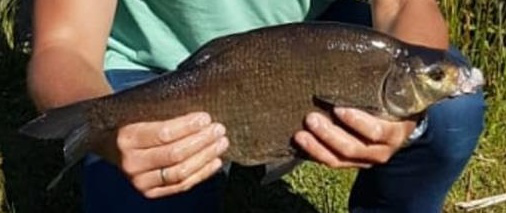

In [14]:
# https://www.kaggle.com/code/mtszkw/reading-sample-image-and-bounding-boxes-from-xml

sample_image = Image.open(dataframe["Filepath"][0])#(filepaths[0])
sample_image

# Adding bounding box to image to read

[20, 20, 486, 193]


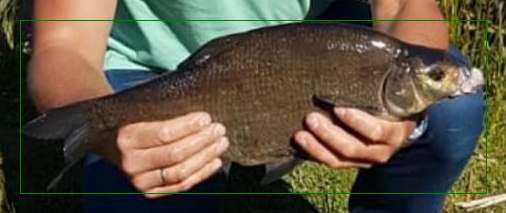

In [15]:
sample_image_boxed = sample_image.copy()

img_bbox = ImageDraw.Draw(sample_image_boxed)

#for i in range(5):
print(boundBoxList[0])
img_bbox.rectangle(boundBoxList[0], outline="green") 
sample_image_boxed

In [ ]:
# From XML file for first image:
#<annotation>
#<size>
#<width>506</width>
#<height>213</height>
#<depth>3</depth>

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(Image.open(dataframe["Filepath"][i]))#.astype("uint8")) #images[i].numpy().astype("uint8"))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(classNameList[i])
    plt.axis("off")
plt.show()

In [ ]:
# Panda dataframe loc and iloc
dataframe.loc[:,"ClassName"]

### Checking for and replacing NaN values in dataframe1

In [ ]:
# Are there any NaN in dataframe1?
#check_nan_in_dataframe = dataframe.isnull().values.any()
#print (check_nan_in_dataframe)

# Is there any Filepath values that are NaN?
#check_for_nan = dataframe['Filepath'].isnull().values.any()
#print (check_for_nan)

# How many count of NaN in Filepath
#count_nan = dataframe['Filepath'].isnull().sum()
#print ('Count of NaN: ' + str(count_nan))

# Replace all NaN values in Filepath column
#dataframe['Filepath'] = dataframe1['Filepath'].fillna(0)

# Are there any NaN values in dataframe1 after replacing them?
#check_nan_in_dataframe = dataframe1.isnull().values.any()
#print (check_nan_in_dataframe1)

## Use sklearn StratifiedShuffleSplit to split into test and train subsets

### From https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [16]:
# Splitting the dataframe
dataframe1 = dataframe.copy()
dataframe1 = dataframe1.pop('Label')

X = dataframe#.to_numpy()# np.asarray(dataframe) - features/columns(has to be 2 dimensional, f
y = dataframe1#.to_numpy()# np.asarray(dataframe1) - Labels/classnames

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 x 0.8 0.2

In [17]:
X_train.values

array([['C:\\Users\\Rob\\Dataset\\Leuciscus idus\\6e32952e-d65e-44b9-bd07-13037c92f670-500mm.jpg',
        'Leuciscus idus', list([20, 20, 407, 169]), list([427, 189, 3]),
        16],
       ['C:\\Users\\Rob\\Dataset\\Scardinius erythrophthalmus\\9d86131c-cdc0-4784-b0d3-9c793ae43a1a-180mm.jpg',
        'Scardinius erythrophthalmus', list([13, 20, 736, 306]),
        list([756, 326, 3]), 26],
       ['C:\\Users\\Rob\\Dataset\\Sander lucioperca\\111348-560mm.jpg',
        'Sander lucioperca', list([20, 20, 742, 338]),
        list([762, 358, 3]), 25],
       ...,
       ['C:\\Users\\Rob\\Dataset\\Gobio gobio\\91893-110mm.jpg',
        'Gobio gobio', list([20, 20, 589, 228]), list([609, 248, 3]), 12],
       ['C:\\Users\\Rob\\Dataset\\Acipenseridae\\0e3f0fb3-5dc8-4829-bbd7-7f2f38a20632-1000mm.jpg',
        'Acipenseridae', list([20, 20, 541, 194]), list([561, 214, 3]),
        1],
       ['C:\\Users\\Rob\\Dataset\\Esox lucius\\120322-570mm.jpg',
        'Esox lucius', list([20, 20, 388, 

In [18]:
X_train.head() 

,Filepath,ClassName,Boundbox,Size,Label
4720,C:\Users\Rob\Dataset\Leuciscus idus\6e32952e-d...,Leuciscus idus,"[20, 20, 407, 169]","[427, 189, 3]",16
6730,C:\Users\Rob\Dataset\Scardinius erythrophthalm...,Scardinius erythrophthalmus,"[13, 20, 736, 306]","[756, 326, 3]",26
6253,C:\Users\Rob\Dataset\Sander lucioperca\111348-...,Sander lucioperca,"[20, 20, 742, 338]","[762, 358, 3]",25
7020,C:\Users\Rob\Dataset\Silurus glanis\a4026b86-2...,Silurus glanis,"[20, 20, 575, 252]","[595, 272, 3]",27
3668,C:\Users\Rob\Dataset\Gobio gobio\69183-100mm.jpg,Gobio gobio,"[20, 20, 201, 459]","[221, 479, 3]",12


In [19]:
y_train.values

array([16, 26, 25, ..., 12,  1, 10], dtype=int8)

In [20]:
y_train.head()

4720    16
6730    26
6253    25
7020    27
3668    12
Name: Label, dtype: int8

In [21]:
X_train.shape, X_test.shape, X_val.shape

((4488, 5), (1497, 5), (1497, 5))

In [22]:
y_train.shape, y_test.shape, y_val.shape

((4488,), (1497,), (1497,))

# Converting the test, train and val dataframes to datasets

In [23]:
#var_target = dataframe.pop('target')
#new_tf_dataset = tf.data.Dataset.from_tensor_slices((dataframe.values, var_target.values))

trainDataset = tf.data.Dataset.from_tensor_slices(X_train),y_train

testDataset= tf.data.Dataset.from_tensor_slices(X_test),y_test

valDataset = tf.data.Dataset.from_tensor_slices(X_val),y_val

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [159]:
# Image size
batchSize=16
img_height=180
img_width=180
image_size=(img_height,img_width,3)
num_classes = 30

In [ ]:
# Useful information on Kaggle:
# https://www.kaggle.com/code/reighns/augmentations-data-cleaning-and-bounding-boxes (3 May 23)
# Hiding id behing jpg
#dataframe1["Filepath"] = dataframe1["Filepath"].apply(lambda x: str(x) + ".jpg")
#dataframe1

# My model (based on TM358 EMA model)

### Data augmentation

In [ ]:
# Creating the normalisation layer
norm_layer = layers.Normalization(input_shape=(image_size))
norm_layer.adapt(train_dataset.map(lambda x, y: x))

In [ ]:
# Creating an augmented subset
data_augmentation = tf.keras.Sequential([
layers.RandomRotation(0.2),
#layers.RandomZoom(height_factor=0.1),
layers.RandomFlip(mode='horizontal')
])

aug_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
num_parallel_calls=tf.data.AUTOTUNE)
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model creation

In [158]:
# Define function to create model and compile
def build_model():
    model = Sequential([
        #norm_layer, # to normalise data - making training freeze
        Conv2D(filters=16, kernel_size=(3,3), padding='same',
        input_shape=image_size, activation='relu'),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',#(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

In [160]:
# Build the model using the build_model function
model=build_model()

In [161]:
# Show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        9

### Train the model

In [173]:
# Train the model
#with tf.device("/device:GPU:0"):
hist=model.fit(
trainDataset,#aug_train_dataset, 
validation_data=valDataset,#val_dataset, 
verbose=1,
epochs=5)

ValueError: Failed to find data adapter that can handle input: (<class 'tuple'> containing values of types {"<class 'numpy.ndarray'>", "<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>"}), <class 'NoneType'>

In [ ]:
# Plotting training loss and accuracy as well as validation loss and accuracy over the number of epochs
hist_dict = hist.history

# obtain the accuracy and loss of the training set and verification set in the returned
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Evaluating the model (based on code from TM358)

In [ ]:
model.evaluate(test_dataset, return_dict=True)

In [ ]:
test_predictions=model.predict(test_dataset)
test_predictions.shape

In [ ]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels.shape

In [ ]:
actual_labels=np.array(list(test_dataset.unbatch().map(lambda x,y: y).as_numpy_iterator()))
#actual_labels=class_names
actual_labels=np.argmax(actual_labels, axis=0)
#actual_labels.shape
#actual_labels
print(actual_labels)

In [ ]:
#  actual_label = LABEL_TEXT[test_labels[i]]

In [ ]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape, sample_labels

In [ ]:
sample_predictions = model(sample_imgs)
# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i].astype("uint8"))
    #plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])#sample
    #plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",# class_names[a_class]
    color=("green" if p_class == a_class else "red"))
    plt.axis("off")
plt.show()